In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [79]:
numenta_results = []
skyline_results = []
knn_results = []
cadose_results = []
originals = []
for i in range(1, 68):
    numenta_results.append(pd.read_csv(f"data_results/NumentaDetectorTM/NumentaDetectorTM_real_{i}.csv"))
    skyline_results.append(pd.read_csv(f"data_results/EarthgeckoSkylineDetector/EarthgeckoSkylineDetector_real_{i}.csv"))
    knn_results.append(pd.read_csv(f"data_results/KnncadDetector/KnncadDetector_real_{i}.csv"))
    cadose_results.append(pd.read_csv(f"data_results/ContextOSEDetector/ContextOSEDetector_real_{i}.csv"))
    originals.append(pd.read_csv(f"data/Yahoo/real_{i}.csv"))    

In [80]:
window_size = 45

In [81]:
cums = []
for i in range(67):
    cums.append(originals[i].copy())
    cums[i]["timestamp"] = numenta_results[i]["timestamp"]
    cums[i]["res_htm"] = numenta_results[i]["anomaly_score"]
    cums[i]["res_earthgecko"] = skyline_results[i]["anomaly_score"]
    cums[i]["res_cadose"] = cadose_results[i]["anomaly_score"]
    cums[i]["res_knn"] = knn_results[i]["anomaly_score"]
    print(cums[i].shape[0], "->", end=" ")
    cums[i] = cums[i][int(cums[i].shape[0] * 0.15) - window_size: ]
    cums[i]["value"] = (cums[i]["value"] - cums[i]["value"].min()) / (cums[i]["value"].max() -  cums[i]["value"].min())
    print(cums[i].shape[0])

1420 -> 1252
1439 -> 1269
1461 -> 1287
1423 -> 1255
1439 -> 1269
1439 -> 1269
1423 -> 1255
1420 -> 1252
1461 -> 1287
1439 -> 1269
1439 -> 1269
1439 -> 1269
1439 -> 1269
1439 -> 1269
1439 -> 1269
1461 -> 1287
1424 -> 1256
1461 -> 1287
1424 -> 1256
1422 -> 1254
1420 -> 1252
1420 -> 1252
1420 -> 1252
1461 -> 1287
1435 -> 1265
1435 -> 1265
1427 -> 1258
1441 -> 1270
1441 -> 1270
1461 -> 1287
1427 -> 1258
1427 -> 1258
1439 -> 1269
1427 -> 1258
1427 -> 1258
1461 -> 1287
1434 -> 1264
1427 -> 1258
1427 -> 1258
1427 -> 1258
1435 -> 1265
1440 -> 1269
1440 -> 1269
1461 -> 1287
1440 -> 1269
1441 -> 1270
1427 -> 1258
1439 -> 1269
1461 -> 1287
1439 -> 1269
1427 -> 1258
1432 -> 1263
1461 -> 1287
741 -> 675
1427 -> 1258
1427 -> 1258
1441 -> 1270
1435 -> 1265
1423 -> 1255
1461 -> 1287
1441 -> 1270
741 -> 675
1439 -> 1269
1441 -> 1270
1424 -> 1256
1424 -> 1256
1423 -> 1255


In [82]:
anom_len = 3
for i in range(67):
    cums[i]["is_anomaly"] = cums[i]["is_anomaly"].shift(-1 * (anom_len - 1)).rolling(anom_len).max().fillna(0)

               timestamp     value  is_anomaly   res_htm  res_earthgecko  \
168  2021-01-01 00:02:48  0.157479         0.0  0.030103             0.0   
169  2021-01-01 00:02:49  0.191550         0.0  0.030103             0.0   
170  2021-01-01 00:02:50  0.240877         0.0  0.030103             0.0   
171  2021-01-01 00:02:51  0.076879         0.0  0.030103             0.0   
172  2021-01-01 00:02:52  0.091546         0.0  0.030103             0.0   

     res_cadose  res_knn  
168    0.214674      0.0  
169    0.269841      0.0  
170    0.260684      0.0  
171    0.161667      0.0  
172    0.201863      0.0  


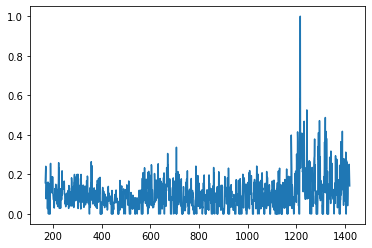

In [83]:
plt.plot(cums[0]["value"])
print(cums[0].head())

In [84]:
def get_features(values: pd.DataFrame, rolling_size=5):
    diffed = values.diff()
    abs_diffed = np.abs(diffed)

    X = pd.DataFrame(index=[0], dtype=np.float64)
    X['min_values'] = values.min()
    X['max_values'] = values.max()
    X['mean_values'] = values.mean()
    X['std_values'] = values.std()
    X['median_values'] = values.median()

    X['max_rolling_sum_values'] = values.rolling(rolling_size).sum().max()
    X['last_rolling_sum_values'] = values[-1 * rolling_size:].sum()
    X['std_rolling_mean_values'] = values.rolling(rolling_size).mean().std()
    X['rolling_mean_75_percentile_values'] = np.percentile(values.rolling(rolling_size).mean().dropna().values, 75)

    X['min_diff'] = diffed.min()
    X['max_diff'] = diffed.max()
    X['mean_diff'] = diffed.mean()

    X['max_abs_diff'] = abs_diffed.max()
    X['mean_abs_diff'] = abs_diffed.mean()
    X['std_abs_diff'] = abs_diffed.std()

    return X


def get_windows(df: pd.DataFrame, window_size=45):
    stop_index = df.shape[0] - window_size + 1
    start_index = 0
    while start_index < stop_index:
        yield df["value"][start_index: start_index + window_size], \
              df["res_htm"].values[start_index + window_size - 1], \
              df["res_earthgecko"].values[start_index + window_size - 1], \
              df["res_cadose"].values[start_index + window_size - 1], \
              df["res_knn"].values[start_index + window_size - 1], \
              df["is_anomaly"].values[start_index + window_size - 1]
        start_index += 1


def transform_window(window):
    features = get_features(window[0])

    features['val'] = window[0].values[-1]
    features['pred_htm'] = window[1]
    features['pred_etsy'] = window[2]
    features['pred_cadose'] = window[3]
    features['pred_knn'] = window[4]

    features['label'] = window[5]
    return features

In [85]:
def create_feature_dataset_from_raw_dataset(raw_df):
    return pd.concat([transform_window(window) for window in get_windows(raw_df)])


def add_decaying_means_to_dataset(features_df):
    # TODO: Z SCORE
    columns = ['min_values', 'max_values', 'mean_values', 'std_values',
               'median_values', 'max_rolling_sum_values', 'std_rolling_mean_values', 
               'rolling_mean_75_percentile_values', 'min_diff', 'max_diff', 'mean_diff', 
               'max_abs_diff', 'mean_abs_diff', 'std_abs_diff']
    for col_name in columns:
        decayed_means = get_decayed_mean_and_range_so_far(features_df[col_name])
        features_df[f'{col_name}_usual'] = decayed_means
    return features_df


def get_decayed_mean_and_range_so_far(series: pd.Series):
    decayed_mean = series.copy()

    prev_mean = series.values[0]

    index = 1
    for val in series[:-1].values:
        prev_mean = (49 * prev_mean + val) / 50
        decayed_mean.values[index] = prev_mean

        index += 1
    return decayed_mean

In [86]:
def create_dataset(dfs):
    as_list = []
    for df in dfs:
        features = create_feature_dataset_from_raw_dataset(df)
        print(f"{df.shape[0]} -> {features.shape[0]} feature rows")
        as_list.append(add_decaying_means_to_dataset(features))
        print("done")

    return pd.concat(as_list)

In [14]:
full = create_dataset(cums)

1252 -> 1208 feature rows
done
1269 -> 1225 feature rows
done
1287 -> 1243 feature rows
done
1255 -> 1211 feature rows
done
1269 -> 1225 feature rows
done
1269 -> 1225 feature rows
done
1255 -> 1211 feature rows
done
1252 -> 1208 feature rows
done
1287 -> 1243 feature rows
done
1269 -> 1225 feature rows
done
1269 -> 1225 feature rows
done
1269 -> 1225 feature rows
done
1269 -> 1225 feature rows
done
1269 -> 1225 feature rows
done
1269 -> 1225 feature rows
done
1287 -> 1243 feature rows
done
1256 -> 1212 feature rows
done
1287 -> 1243 feature rows
done
1256 -> 1212 feature rows
done
1254 -> 1210 feature rows
done
1252 -> 1208 feature rows
done
1252 -> 1208 feature rows
done
1252 -> 1208 feature rows
done
1287 -> 1243 feature rows
done
1265 -> 1221 feature rows
done
1265 -> 1221 feature rows
done
1258 -> 1214 feature rows
done
1270 -> 1226 feature rows
done
1270 -> 1226 feature rows
done
1287 -> 1243 feature rows
done
1258 -> 1214 feature rows
done
1258 -> 1214 feature rows
done
1269 -> 

In [18]:
full.to_csv("full.csv")

In [10]:
full = pd.read_csv("full_normalized_both.csv")
for colname in full.columns:
    if "Unnamed" in colname:
        full = full.drop(colname, axis='columns')
bset = pd.read_csv("bset.csv")
for colname in bset.columns:
    if "Unnamed" in colname:
        bset = bset.drop(colname, axis='columns')

In [88]:
full

,min_values,max_values,mean_values,std_values,median_values,max_rolling_sum_values,last_rolling_sum_values,std_rolling_mean_values,rolling_mean_75_percentile_values,min_diff,...,median_values_usual,max_rolling_sum_values_usual,std_rolling_mean_values_usual,rolling_mean_75_percentile_values_usual,min_diff_usual,max_diff_usual,mean_diff_usual,max_abs_diff_usual,mean_abs_diff_usual,std_abs_diff_usual
0,0.00000,0.255517,0.112302,0.060738,0.105950,0.890798,0.577608,0.034403,0.135541,-0.163998,...,0.105950,0.890798,0.034403,0.135541,-0.163998,0.252060,-0.000670,0.252060,0.053006,0.050168
1,0.00000,0.255517,0.110304,0.060696,0.105026,0.890798,0.560640,0.033704,0.134151,-0.163998,...,0.105950,0.890798,0.034403,0.135541,-0.163998,0.252060,-0.000670,0.252060,0.053006,0.050168
2,0.00000,0.255517,0.108852,0.059477,0.105026,0.890798,0.597287,0.033330,0.133573,-0.163998,...,0.105932,0.890798,0.034389,0.135513,-0.163998,0.252060,-0.000712,0.252060,0.053018,0.050167
3,0.00000,0.255517,0.104834,0.056383,0.104635,0.890798,0.531854,0.033041,0.130510,-0.153821,...,0.105914,0.890798,0.034368,0.135475,-0.163998,0.252060,-0.000750,0.252060,0.053034,0.050165
4,0.00000,0.255517,0.105702,0.056243,0.105026,0.890798,0.497839,0.033037,0.130510,-0.153821,...,0.105888,0.890798,0.034341,0.135375,-0.163794,0.252060,-0.000743,0.252060,0.053005,0.050106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80719,0.00008,1.000000,0.246489,0.324870,0.008730,3.675957,1.318757,0.212660,0.425773,-0.999039,...,0.006116,1.472148,0.085036,0.116307,-0.478896,0.402258,0.003410,0.489265,0.053616,0.111474
80720,0.00008,1.000000,0.262066,0.329879,0.009451,3.675957,2.025709,0.210463,0.425773,-0.999039,...,0.006169,1.516224,0.087588,0.122496,-0.489299,0.410550,0.003585,0.499460,0.056245,0.114536
80721,0.00008,1.000000,0.273489,0.329755,0.010011,3.675957,2.546532,0.210125,0.426974,-0.999039,...,0.006234,1.559419,0.090046,0.128562,-0.499494,0.418675,0.003831,0.509452,0.058898,0.117507
80722,0.00008,1.000000,0.290094,0.334792,0.011773,3.675957,3.299055,0.214407,0.430722,-0.999039,...,0.006310,1.601750,0.092447,0.134530,-0.509485,0.426639,0.003988,0.519244,0.061583,0.120386


In [41]:
bset

,min_values,max_values,mean_values,std_values,median_values,max_rolling_sum_values,std_rolling_mean_values,rolling_mean_75_percentile_values,min_diff,max_diff,...,median_values_usual,max_rolling_sum_values_usual,std_rolling_mean_values_usual,rolling_mean_75_percentile_values_usual,min_diff_usual,max_diff_usual,mean_diff_usual,max_abs_diff_usual,mean_abs_diff_usual,std_abs_diff_usual
0,125278.0,146614.0,132250.288889,4658.054367,131417.0,687473.0,2347.616905,134627.6,-14354.0,19178.0,...,1.314170e+05,687473.000000,2.347617e+03,1.346276e+05,-1.435400e+04,1.917800e+04,-2.548182e+02,1.917800e+04,4.740909e+03,4.443329e+03
1,125278.0,146614.0,132169.244444,4614.131673,131417.0,687473.0,2432.668034,134627.6,-14354.0,19178.0,...,1.314170e+05,687473.000000,2.347617e+03,1.346276e+05,-1.435400e+04,1.917800e+04,-2.548182e+02,1.917800e+04,4.740909e+03,4.443329e+03
2,125278.0,146614.0,132271.866667,4598.260297,131737.0,687473.0,2435.963732,134627.6,-14354.0,19178.0,...,1.314170e+05,687473.000000,2.349318e+03,1.346276e+05,-1.435400e+04,1.917800e+04,-2.480727e+02,1.917800e+04,4.741041e+03,4.443410e+03
3,125118.0,146614.0,132131.888889,4719.161117,131737.0,687473.0,2475.097121,134627.6,-14354.0,19178.0,...,1.314234e+05,687473.000000,2.351051e+03,1.346276e+05,-1.435400e+04,1.917800e+04,-2.420131e+02,1.917800e+04,4.740619e+03,4.443887e+03
4,125118.0,146614.0,132102.311111,4730.452351,131737.0,687473.0,2476.289130,134627.6,-14354.0,19178.0,...,1.314297e+05,687473.000000,2.353532e+03,1.346276e+05,-1.435400e+04,1.917800e+04,-2.398551e+02,1.917800e+04,4.743986e+03,4.444130e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250339,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,8.274239e-07,0.000006,2.620105e-07,1.018430e-06,-5.641525e-07,9.814370e-08,-1.732569e-08,5.714067e-07,4.185442e-08,9.515719e-08
250340,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,8.108754e-07,0.000006,2.567703e-07,9.980617e-07,-5.528695e-07,9.618082e-08,-1.697918e-08,5.599785e-07,4.101734e-08,9.325404e-08
250341,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,7.946579e-07,0.000006,2.516348e-07,9.781005e-07,-5.418121e-07,9.425721e-08,-1.663960e-08,5.487790e-07,4.019699e-08,9.138896e-08
250342,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,7.787647e-07,0.000006,2.466022e-07,9.585385e-07,-5.309759e-07,9.237206e-08,-1.630680e-08,5.378034e-07,3.939305e-08,8.956118e-08


In [11]:
def score_f1(positives, negatives, col_name, threshold):
    tp = (positives[col_name] >= threshold).sum()
    fp = (negatives[col_name] >= threshold).sum()
    fn = (positives[col_name] < threshold).sum()
#     print(tp, fp, fn)
#     print(tp / (tp + (fp + fn) / 2))
    return tp / (tp + (fp + fn) / 2)
def precision(positives, negatives, col_name, threshold):
    tp = (positives[col_name] >= threshold).sum()
    fp = (negatives[col_name] >= threshold).sum()
    return tp / (tp + fp)
def recall(positives, negatives, col_name, threshold):
    tp = (positives[col_name] >= threshold).sum()
    fn = (positives[col_name] < threshold).sum()
    return tp / (tp + fn)

In [21]:
from nimbusml.ensemble import LightGbmClassifier
from nimbusml import Pipeline
from sklearn.model_selection import train_test_split
from random import random

state = int(random() * 10000)

#train, test = train_test_split(full, test_size=0.9, train_size=0.1, random_state=state)
train = full[:60000]
test = full[60000:]
print(full.shape, train.shape, test.shape)

(80724, 35) (60000, 35) (20724, 35)


In [22]:
print(state)
train_x_both = train[[colname for colname in train.columns if 'label' not in colname and "etsy" not in colname]]
train_y_both = train['label']
test_x_both = test[[colname for colname in test.columns if 'label' not in colname and "etsy" not in colname]]
test_y_both = test['label']
pipeline_both = Pipeline([LightGbmClassifier(unbalanced_sets=True,
                                             learning_rate=0.1,
                                             number_of_leaves=50,
                                             sigmoid=0.05,
                                             evaluation_metric="LogLoss")])
pipeline_both.fit(train_x_both, train_y_both)
res_both = pipeline_both.predict(test_x_both)
res_both["label"] = test_y_both.values
positives_both = res_both[res_both["label"] == 1]
negatives_both = res_both[res_both["label"] == 0]

1862
Not adding a normalizer.
Auto-tuning parameters: UseCategoricalSplit = True
Auto-tuning parameters: MinimumExampleCountPerLeaf = 50
Auto-tuning parameters: UseSoftmax = True
LightGBM objective=multiclass
Not training a calibrator because it is not needed.
Elapsed time: 00:00:01.5997915


In [23]:
for t in train_x_both.columns:
    print(t)
print(train_x_nopred.shape)

min_values
max_values
mean_values
std_values
median_values
max_rolling_sum_values
last_rolling_sum_values
std_rolling_mean_values
rolling_mean_75_percentile_values
min_diff
max_diff
mean_diff
max_abs_diff
mean_abs_diff
std_abs_diff
val
pred_htm
pred_cadose
pred_knn
min_values_usual
max_values_usual
mean_values_usual
std_values_usual
median_values_usual
max_rolling_sum_values_usual
std_rolling_mean_values_usual
rolling_mean_75_percentile_values_usual
min_diff_usual
max_diff_usual
mean_diff_usual
max_abs_diff_usual
mean_abs_diff_usual
std_abs_diff_usual
(60724, 30)


In [24]:
print(state)
train_x_pred = train[[colname for colname in train.columns if 'pred' in colname and "etsy" not in colname]]
train_y_pred = train['label']
test_x_pred = test[[colname for colname in test.columns if 'pred' in colname and "etsy" not in colname]]
test_y_pred = test['label']
pipeline_pred = Pipeline([LightGbmClassifier(unbalanced_sets=True,
                                             learning_rate=0.1,
                                             number_of_leaves=35,
                                             sigmoid=0.05,
                                             evaluation_metric="LogLoss")])
pipeline_pred.fit(train_x_pred, train_y_pred)
res_pred = pipeline_pred.predict(test_x_pred)
res_pred["label"] = test_y_pred.values
positives_pred = res_pred[res_pred["label"] == 1]
negatives_pred = res_pred[res_pred["label"] == 0]

1862
Not adding a normalizer.
Auto-tuning parameters: UseCategoricalSplit = True
Auto-tuning parameters: MinimumExampleCountPerLeaf = 50
Auto-tuning parameters: UseSoftmax = True
LightGBM objective=multiclass
Not training a calibrator because it is not needed.
Elapsed time: 00:00:00.4705786


In [25]:
print(state)
train_x_nopred = train[[colname for colname in train.columns if 'label' not in colname and "pred" not in colname]]
train_y_nopred = train['label']
test_x_nopred = test[[colname for colname in test.columns if 'label' not in colname and "pred" not in colname]]
test_y_nopred = test['label']
pipeline_nopred = Pipeline([LightGbmClassifier(unbalanced_sets=True,
                                               learning_rate=0.1,
                                               number_of_leaves=35,
                                               sigmoid=0.05,
                                               evaluation_metric="LogLoss")])
pipeline_nopred.fit(train_x_nopred, train_y_nopred)
res_nopred = pipeline_nopred.predict(test_x_nopred)
res_nopred["label"] = test_y_nopred.values
positives_nopred = res_nopred[res_nopred["label"] == 1]
negatives_nopred = res_nopred[res_nopred["label"] == 0]

1862
Not adding a normalizer.
Auto-tuning parameters: UseCategoricalSplit = True
Auto-tuning parameters: MinimumExampleCountPerLeaf = 50
Auto-tuning parameters: UseSoftmax = True
LightGBM objective=multiclass
Not training a calibrator because it is not needed.
Elapsed time: 00:00:01.1103693


<ipython-input-11-193b7379f05a>:11: RuntimeWarning: invalid value encountered in longlong_scalars
  return tp / (tp + fp)
<ipython-input-11-193b7379f05a>:11: RuntimeWarning: invalid value encountered in longlong_scalars
  return tp / (tp + fp)
<ipython-input-11-193b7379f05a>:11: RuntimeWarning: invalid value encountered in longlong_scalars
  return tp / (tp + fp)
<ipython-input-11-193b7379f05a>:11: RuntimeWarning: invalid value encountered in longlong_scalars
  return tp / (tp + fp)
<ipython-input-11-193b7379f05a>:11: RuntimeWarning: invalid value encountered in longlong_scalars
  return tp / (tp + fp)
<ipython-input-11-193b7379f05a>:11: RuntimeWarning: invalid value encountered in longlong_scalars
  return tp / (tp + fp)
<ipython-input-11-193b7379f05a>:11: RuntimeWarning: invalid value encountered in longlong_scalars
  return tp / (tp + fp)
<ipython-input-11-193b7379f05a>:11: RuntimeWarning: invalid value encountered in longlong_scalars
  return tp / (tp + fp)
<ipython-input-11-193b73

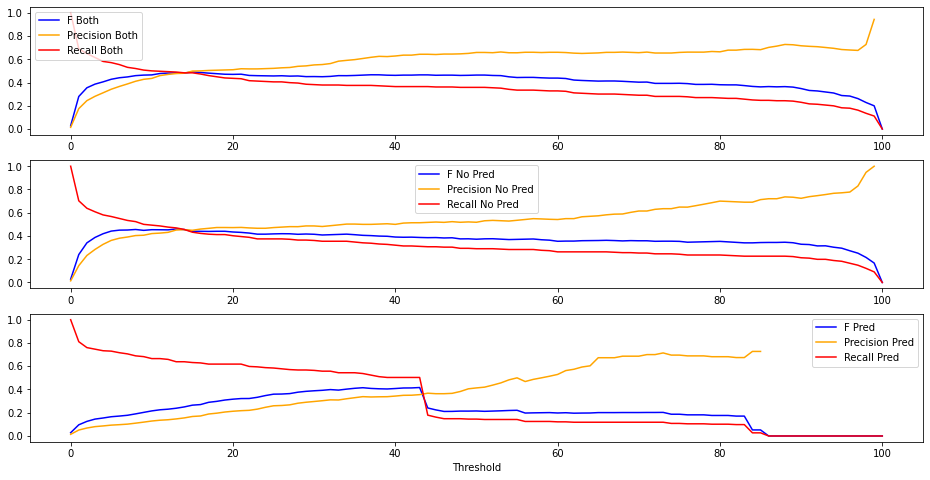

In [26]:
fig, axs = plt.subplots(3, figsize=(16,8))
axs[0].plot([score_f1(positives_both, negatives_both, "Score.1", th / 100) for th in range(101)], 'blue', label="F Both")
axs[0].plot([precision(positives_both, negatives_both, "Score.1", th / 100) for th in range(101)], 'orange', label='Precision Both')
axs[0].plot([recall(positives_both, negatives_both, "Score.1", th / 100) for th in range(101)], 'red', label='Recall Both')

axs[1].plot([score_f1(positives_nopred, negatives_nopred, "Score.1", th / 100) for th in range(101)], 'blue', label="F No Pred")
axs[1].plot([precision(positives_nopred, negatives_nopred, "Score.1", th / 100) for th in range(101)], 'orange', label='Precision No Pred')
axs[1].plot([recall(positives_nopred, negatives_nopred, "Score.1", th / 100) for th in range(101)], 'red', label='Recall No Pred')

axs[2].plot([score_f1(positives_pred, negatives_pred, "Score.1", th / 100) for th in range(101)], 'blue', label="F Pred")
axs[2].plot([precision(positives_pred, negatives_pred, "Score.1", th / 100) for th in range(101)], 'orange', label='Precision Pred')
axs[2].plot([recall(positives_pred, negatives_pred, "Score.1", th / 100) for th in range(101)], 'red', label='Recall Pred')

axs[2].set_xlabel("Threshold")
axs[0].legend()
axs[1].legend()
axs[2].legend()

In [30]:
max([score_f1(positives_both, negatives_both, "Score.1", th / 100) for th in range(101)])

0.49056603773584906

In [75]:
negatives_pred

,PredictedLabel,Score.0,Score.1,label
0,0.0,0.800298,0.199702,0.0
1,0.0,0.998354,0.001646,0.0
2,0.0,0.995999,0.004001,0.0
3,0.0,0.990961,0.009039,0.0
4,0.0,0.917087,0.082913,0.0
...,...,...,...,...
72647,0.0,0.859694,0.140306,0.0
72648,0.0,0.980938,0.019062,0.0
72649,1.0,0.042956,0.957044,0.0
72650,0.0,0.908264,0.091736,0.0


<ipython-input-12-193b7379f05a>:11: RuntimeWarning: invalid value encountered in longlong_scalars
  return tp / (tp + fp)


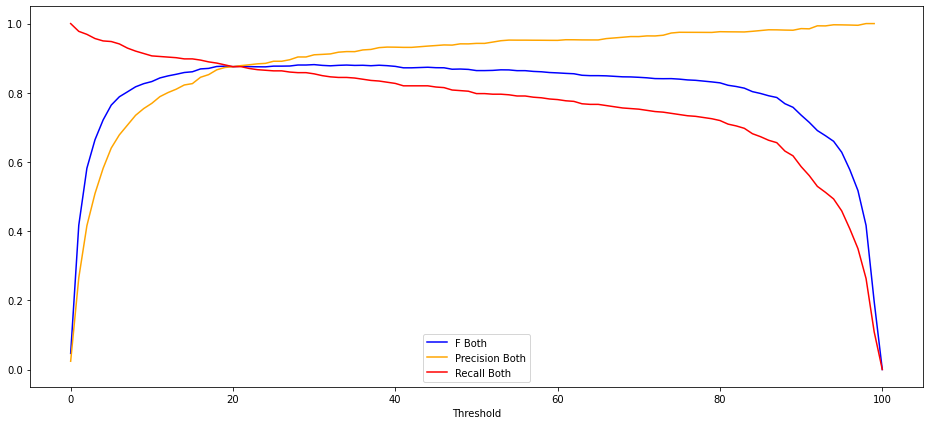

In [33]:
plt.figure(figsize=(16,7))
plt.plot([score_f1(positives_both, negatives_both, "Score.1", th / 100) for th in range(101)], 'blue', label="F Both")
plt.plot([precision(positives_both, negatives_both, "Score.1", th / 100) for th in range(101)], 'orange', label='Precision Both')
plt.plot([recall(positives_both, negatives_both, "Score.1", th / 100) for th in range(101)], 'red', label='Recall Both')
plt.xlabel("Threshold")
plt.legend()

<ipython-input-12-193b7379f05a>:11: RuntimeWarning: invalid value encountered in longlong_scalars
  return tp / (tp + fp)


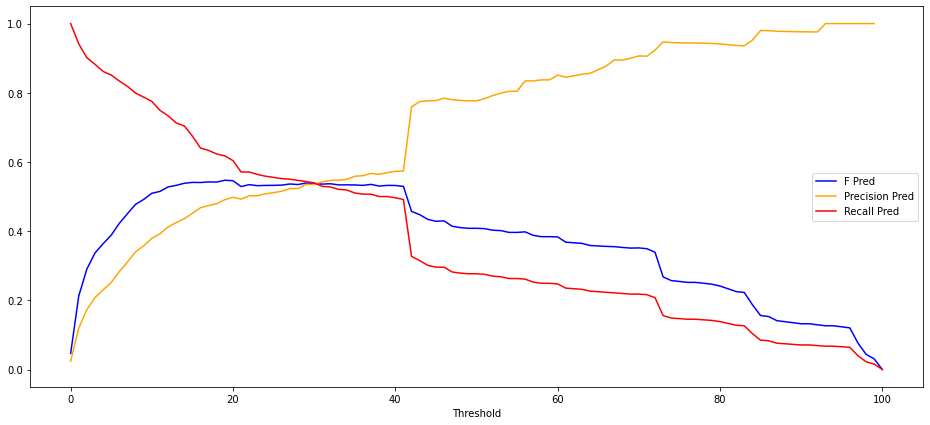

In [34]:
plt.figure(figsize=(16,7))

plt.plot([score_f1(positives_pred, negatives_pred, "Score.1", th / 100) for th in range(101)], 'blue', label="F Pred")
plt.plot([precision(positives_pred, negatives_pred, "Score.1", th / 100) for th in range(101)], 'orange', label='Precision Pred')
plt.plot([recall(positives_pred, negatives_pred, "Score.1", th / 100) for th in range(101)], 'red', label='Recall Pred')
plt.xlabel("Threshold")
plt.legend()

<ipython-input-12-193b7379f05a>:11: RuntimeWarning: invalid value encountered in longlong_scalars
  return tp / (tp + fp)


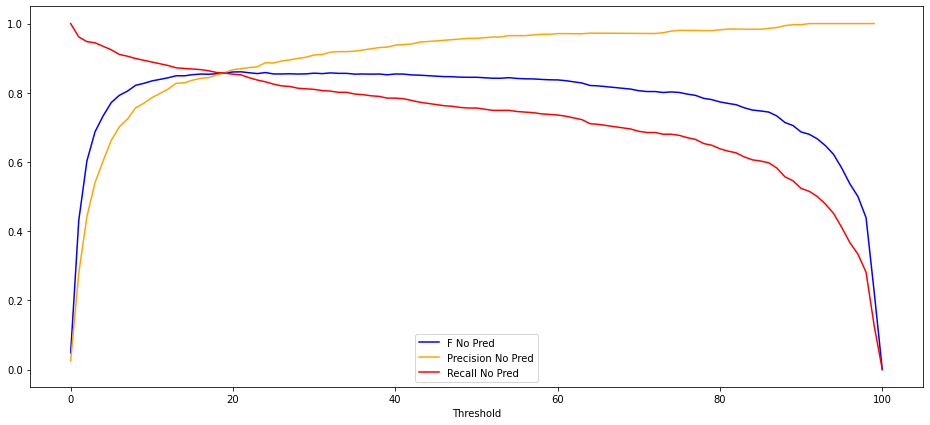

In [35]:
plt.figure(figsize=(16,7))

plt.plot([score_f1(positives_nopred, negatives_nopred, "Score.1", th / 100) for th in range(101)], 'blue', label="F No Pred")
plt.plot([precision(positives_nopred, negatives_nopred, "Score.1", th / 100) for th in range(101)], 'orange', label='Precision No Pred')
plt.plot([recall(positives_nopred, negatives_nopred, "Score.1", th / 100) for th in range(101)], 'red', label='Recall No Pred')
plt.xlabel("Threshold")
plt.legend()

In [ ]:
'mediumvioletred', 'deeppink', 'hotpink',
'coral', 'brown', 'red',
'forestgreen', 'lime', 'darkgreen'

In [27]:
negatives

,PredictedLabel,Score.0,Score.1,label
0,0.0,0.997862,0.002138,0.0
1,0.0,0.997934,0.002066,0.0
2,0.0,0.996261,0.003739,0.0
3,0.0,0.997681,0.002319,0.0
4,0.0,0.997766,0.002234,0.0
...,...,...,...,...
30713,0.0,0.936522,0.063478,0.0
30714,0.0,0.936522,0.063478,0.0
30715,0.0,0.936075,0.063925,0.0
30722,1.0,0.222213,0.777787,0.0


In [44]:
p = pipeline.predict(bset[[colname for colname in bset.columns if 'label' not in colname and 'etsy' not in colname]])

In [47]:
def read_NAB_file(fname, folder):
    base = "NAB/results/"
    df = pd.read_csv(base + "NumentaTM/" + folder + "/NumentaTM_" + fname)
    df = df.rename(columns={"anomaly_score": "res_htm", "label": "is_anomaly"})
    df = df.drop([col for col in df.columns if "S(t)" in col], axis='columns')
    df = df.drop("raw_score", axis="columns")
    df["res_cadose"] = pd.read_csv(base + "contextOSE/" + folder + "/contextOSE_" + fname)["anomaly_score"]
    df["res_knn"] = pd.read_csv(base + "knncad/" + folder + "/knncad_" + fname)["anomaly_score"]
    df["res_earthgecko"] = pd.read_csv(base + "earthgeckoSkyline/" + folder + "/earthgeckoSkyline_" + fname)["anomaly_score"]
#     df["value"] = (df["value"] - df["value"].min()) / (df["value"].max() -  df["value"].min())

    return df

In [48]:
import glob
NAB = {}
for x in glob.glob("NAB/results/NumentaTM/*/*.csv"):
    f = x.split("\\")[-1].split("numentaTM_")[-1]
    fo = x.split("\\")[1]
    NAB[f"{fo}/{f}"] = read_NAB_file(f, fo)    
sum([f.shape[0] for _,f in NAB.items()])

365558

In [14]:
NAB

{'artificialNoAnomaly/art_daily_no_noise.csv':                 timestamp     value   res_htm  is_anomaly  res_cadose  \
 0     2014-04-01 00:00:00  0.000000  0.030103           0       0.000   
 1     2014-04-01 00:05:00  0.000000  0.030103           0       0.000   
 2     2014-04-01 00:10:00  0.000000  0.030103           0       0.000   
 3     2014-04-01 00:15:00  0.000000  0.030103           0       0.000   
 4     2014-04-01 00:20:00  0.000000  0.030103           0       0.000   
 ...                   ...       ...       ...         ...         ...   
 4027  2014-04-14 23:35:00  0.000064  0.016325           0       0.225   
 4028  2014-04-14 23:40:00  0.000064  0.016325           0       0.225   
 4029  2014-04-14 23:45:00  0.000064  0.016325           0       0.225   
 4030  2014-04-14 23:50:00  0.000064  0.016325           0       0.225   
 4031  2014-04-14 23:55:00  0.000064  0.016325           0       0.225   
 
        res_knn  res_earthgecko  
 0     0.000000             0.

In [15]:
ere = create_dataset([NAB['artificialNoAnomaly/art_flatline.csv']])

4032 -> 3988 feature rows
done


In [16]:
dsets = {k: create_dataset([f]) for k,f in NAB.items()}

4032 -> 3988 feature rows
done
4032 -> 3988 feature rows
done
4032 -> 3988 feature rows
done
4032 -> 3988 feature rows
done
4032 -> 3988 feature rows
done
4032 -> 3988 feature rows
done
4032 -> 3988 feature rows
done
4032 -> 3988 feature rows
done
4032 -> 3988 feature rows
done
4032 -> 3988 feature rows
done
4032 -> 3988 feature rows
done
1624 -> 1580 feature rows
done
1624 -> 1580 feature rows
done
1538 -> 1494 feature rows
done
1538 -> 1494 feature rows
done
1643 -> 1599 feature rows
done
1643 -> 1599 feature rows
done
4032 -> 3988 feature rows
done
4032 -> 3988 feature rows
done
4032 -> 3988 feature rows
done
4032 -> 3988 feature rows
done
4032 -> 3988 feature rows
done
4032 -> 3988 feature rows
done
4032 -> 3988 feature rows
done
4032 -> 3988 feature rows
done
4730 -> 4686 feature rows
done
4032 -> 3988 feature rows
done
4032 -> 3988 feature rows
done
4730 -> 4686 feature rows
done
4032 -> 3988 feature rows
done
4621 -> 4577 feature rows
done
1243 -> 1199 feature rows
done
4032 -> 

In [18]:
i = 0
for k,d in dsets.items():
    d.to_csv(f"data/NAB/{i}.csv")
    i += 1

In [19]:
dsets["artificialNoAnomaly/art_daily_no_noise.csv"]

,min_values,max_values,mean_values,std_values,median_values,max_rolling_sum_values,last_rolling_sum_values,std_rolling_mean_values,rolling_mean_75_percentile_values,min_diff,...,median_values_usual,max_rolling_sum_values_usual,std_rolling_mean_values_usual,rolling_mean_75_percentile_values_usual,min_diff_usual,max_diff_usual,mean_diff_usual,max_abs_diff_usual,mean_abs_diff_usual,std_abs_diff_usual
0,0.000000,0.000,0.000000,0.000000,0.00000,0.000,0.00000,0.000000,0.00000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.000,0.000000,0.000000,0.00000,0.000,0.00000,0.000000,0.00000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.000,0.000000,0.000000,0.00000,0.000,0.00000,0.000000,0.00000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.000,0.000000,0.000000,0.00000,0.000,0.00000,0.000000,0.00000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.000,0.000000,0.000000,0.00000,0.000,0.00000,0.000000,0.00000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.000064,0.040,0.003546,0.006457,0.00160,0.072,0.00032,0.003559,0.00544,-0.0320,...,0.384660,3.072728,0.140724,0.490373,-0.330978,0.037688,-0.007948,0.368663,0.009991,0.056266
0,0.000064,0.008,0.002658,0.003310,0.00160,0.040,0.00032,0.003069,0.00416,-0.0064,...,0.376999,3.012713,0.137981,0.480675,-0.324998,0.036935,-0.007807,0.361930,0.009810,0.055238
0,0.000064,0.008,0.002482,0.003229,0.00160,0.040,0.00032,0.002963,0.00288,-0.0064,...,0.369491,2.953259,0.135283,0.471145,-0.318626,0.036196,-0.007654,0.354819,0.009617,0.054153
0,0.000064,0.008,0.002305,0.003136,0.00032,0.040,0.00032,0.002840,0.00160,-0.0064,...,0.362133,2.894994,0.132636,0.461779,-0.312382,0.035472,-0.007505,0.347851,0.009428,0.053089


In [37]:
NAB["artificialNoAnomaly/art_daily_no_noise.csv"][44:]

,timestamp,value,res_htm,is_anomaly,res_cadose,res_knn,res_earthgecko
44,2014-04-01 03:40:00,0.000000,0.030103,0,0.000,0.000000,0.0
45,2014-04-01 03:45:00,0.000000,0.030103,0,0.000,0.000000,0.0
46,2014-04-01 03:50:00,0.000000,0.030103,0,0.000,0.000000,0.0
47,2014-04-01 03:55:00,0.000000,0.030103,0,0.000,0.000000,0.0
48,2014-04-01 04:00:00,0.000000,0.030103,0,0.000,0.000000,0.0
...,...,...,...,...,...,...,...
4027,2014-04-14 23:35:00,0.000064,0.016325,0,0.225,0.516239,0.0
4028,2014-04-14 23:40:00,0.000064,0.016325,0,0.225,0.517949,0.0
4029,2014-04-14 23:45:00,0.000064,0.016325,0,0.225,0.514530,0.0
4030,2014-04-14 23:50:00,0.000064,0.016325,0,0.225,0.514530,0.0


In [38]:
preds["artificialNoAnomaly/art_daily_no_noise.csv"]

,PredictedLabel,Score.0,Score.1
0,0.0,0.999955,0.000045
1,0.0,0.999955,0.000045
2,0.0,0.999955,0.000045
3,0.0,0.999955,0.000045
4,0.0,0.999955,0.000045
...,...,...,...
3983,0.0,0.988091,0.011909
3984,0.0,0.969183,0.030817
3985,0.0,0.969183,0.030817
3986,0.0,0.969657,0.030343


In [41]:
from nimbusml.ensemble import LightGbmClassifier
from nimbusml import Pipeline

train_x = full[[colname for colname in full.columns if 'label' not in colname and "etsy" not in colname]]
train_y = full['label']

pipeline = Pipeline([LightGbmClassifier(unbalanced_sets=True,
                                        learning_rate=0.1,
                                        number_of_leaves=50,
                                        sigmoid=0.05,
                                        evaluation_metric="LogLoss")])
pipeline.fit(train_x, train_y)

Not adding a normalizer.
Auto-tuning parameters: UseCategoricalSplit = True
Auto-tuning parameters: MinimumExampleCountPerLeaf = 50
Auto-tuning parameters: UseSoftmax = True
LightGBM objective=multiclass
Not training a calibrator because it is not needed.
Elapsed time: 00:00:01.4620299


In [42]:
train_x

,min_values,max_values,mean_values,std_values,median_values,max_rolling_sum_values,last_rolling_sum_values,std_rolling_mean_values,rolling_mean_75_percentile_values,min_diff,...,median_values_usual,max_rolling_sum_values_usual,std_rolling_mean_values_usual,rolling_mean_75_percentile_values_usual,min_diff_usual,max_diff_usual,mean_diff_usual,max_abs_diff_usual,mean_abs_diff_usual,std_abs_diff_usual
0,0.00000,0.255517,0.112302,0.060738,0.105950,0.890798,0.577608,0.034403,0.135541,-0.163998,...,0.105950,0.890798,0.034403,0.135541,-0.163998,0.252060,-0.000670,0.252060,0.053006,0.050168
1,0.00000,0.255517,0.110304,0.060696,0.105026,0.890798,0.560640,0.033704,0.134151,-0.163998,...,0.105950,0.890798,0.034403,0.135541,-0.163998,0.252060,-0.000670,0.252060,0.053006,0.050168
2,0.00000,0.255517,0.108852,0.059477,0.105026,0.890798,0.597287,0.033330,0.133573,-0.163998,...,0.105932,0.890798,0.034389,0.135513,-0.163998,0.252060,-0.000712,0.252060,0.053018,0.050167
3,0.00000,0.255517,0.104834,0.056383,0.104635,0.890798,0.531854,0.033041,0.130510,-0.153821,...,0.105914,0.890798,0.034368,0.135475,-0.163998,0.252060,-0.000750,0.252060,0.053034,0.050165
4,0.00000,0.255517,0.105702,0.056243,0.105026,0.890798,0.497839,0.033037,0.130510,-0.153821,...,0.105888,0.890798,0.034341,0.135375,-0.163794,0.252060,-0.000743,0.252060,0.053005,0.050106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80719,0.00008,1.000000,0.246489,0.324870,0.008730,3.675957,1.318757,0.212660,0.425773,-0.999039,...,0.006116,1.472148,0.085036,0.116307,-0.478896,0.402258,0.003410,0.489265,0.053616,0.111474
80720,0.00008,1.000000,0.262066,0.329879,0.009451,3.675957,2.025709,0.210463,0.425773,-0.999039,...,0.006169,1.516224,0.087588,0.122496,-0.489299,0.410550,0.003585,0.499460,0.056245,0.114536
80721,0.00008,1.000000,0.273489,0.329755,0.010011,3.675957,2.546532,0.210125,0.426974,-0.999039,...,0.006234,1.559419,0.090046,0.128562,-0.499494,0.418675,0.003831,0.509452,0.058898,0.117507
80722,0.00008,1.000000,0.290094,0.334792,0.011773,3.675957,3.299055,0.214407,0.430722,-0.999039,...,0.006310,1.601750,0.092447,0.134530,-0.509485,0.426639,0.003988,0.519244,0.061583,0.120386


In [44]:
preds = {k: pipeline.predict(f[[colname for colname in full.columns if 'label' not in colname and "etsy" not in colname]]) for k,f in dsets.items()}

In [55]:
for k,d in NAB.items():
    a = d[["timestamp", "value"]].copy()
    a["label"] = d["is_anomaly"]
    a["anomaly_score"] = 0
    a["anomaly_score"][44:] = preds[k]["Score.1"].values
    a.to_csv(f"NAB/results/SlidingNewFull/{k.split('/')[0]}/SlidingNewFull_{k.split('/')[1]}")

<ipython-input-55-71f944e557a8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["anomaly_score"][44:] = preds[k]["Score.1"].values
c:\erebere\env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [45]:
for k,d in NAB.items():
    plt.figure(figsize=(16, 6))
    plt.plot(d["value"].values[44:])
    a = plt.twinx()
    a.plot(preds[k]["Score.1"], "orange")
    n = k.replace("/", "")[:-4]
    plt.savefig(f"data_plots/NABnew/{n}_allcol.png")
    plt.close()

In [69]:
for k,p in preds.items():
    p.to_csv(f"data_results/slidingEnsemble/{k[:-4]}_pred_nopred.csv")

In [194]:
for k,d in NAB.items():
    d["htm"] = 0
    d["pred"] = 0
    d["pred"][44:] = preds[k]["Score.1"]
    d["htm"][44:] = dsets[k]["pred_htm"]

<ipython-input-194-e5bc0d3432a8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["pred"][44:] = preds[k]["Score.1"]
c:\erebere\env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-194-e5bc0d3432a8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["htm"][44:] = dsets[k]["pred_htm"]


In [13]:
b = pd.read_csv("idosorok/b.csv")
b["res_htm"] = pd.read_csv("data_results/NumentaDetectorTM/NumentaDetectorTM_b.csv")["anomaly_score"]
b["res_cadose"] = pd.read_csv("data_results/ContextOSEDEtector/ContextOSEDEtector_b.csv")["anomaly_score"]
b["res_knn"] = pd.read_csv("data_results/KnncadDetector/KnncadDetector_b.csv")["anomaly_score"]
b["res_earthgecko"] = 0
b["is_anomaly"] = 0
b = b[int(b.shape[0] * 0.08):]

In [14]:
b.head()

,timestamp,value,res_htm,res_cadose,res_knn,res_earthgecko,is_anomaly
21772,2020-08-20T02:52:00.000,136490.0,0.076159,0.240283,0.612859,0,0
21773,2020-08-20T02:53:00.000,129215.0,0.076159,0.240283,0.642955,0,0
21774,2020-08-20T02:54:00.000,131417.0,0.076159,0.240283,0.636115,0,0
21775,2020-08-20T02:55:00.000,131019.0,0.076159,0.240283,0.644323,0,0
21776,2020-08-20T02:56:00.000,129135.0,0.076159,0.240283,0.629275,0,0


In [19]:
bset = create_dataset([b])

250388 -> 250344 feature rows
done


In [28]:
train_x

,Unnamed: 0,Unnamed: 0.1,min_values,max_values,mean_values,std_values,median_values,max_rolling_sum_values,std_rolling_mean_values,rolling_mean_75_percentile_values,...,median_values_usual,max_rolling_sum_values_usual,std_rolling_mean_values_usual,rolling_mean_75_percentile_values_usual,min_diff_usual,max_diff_usual,mean_diff_usual,max_abs_diff_usual,mean_abs_diff_usual,std_abs_diff_usual
0,0,0,0.0,0.201124,0.088396,0.047808,0.083396,0.70117,0.027080,0.106688,...,0.083396,0.701170,0.027080,0.106688,-0.129087,0.198403,-0.000527,0.198403,0.041722,0.039489
1,1,0,0.0,0.201124,0.086823,0.047775,0.082669,0.70117,0.026530,0.105594,...,0.083396,0.701170,0.027080,0.106688,-0.129087,0.198403,-0.000527,0.198403,0.041722,0.039489
2,2,0,0.0,0.201124,0.085681,0.046816,0.082669,0.70117,0.026235,0.105139,...,0.083382,0.701170,0.027069,0.106666,-0.129087,0.198403,-0.000561,0.198403,0.041732,0.039488
3,3,0,0.0,0.201124,0.082518,0.044380,0.082361,0.70117,0.026008,0.102728,...,0.083368,0.701170,0.027052,0.106636,-0.129087,0.198403,-0.000591,0.198403,0.041744,0.039487
4,4,0,0.0,0.201124,0.083201,0.044270,0.082669,0.70117,0.026004,0.102728,...,0.083347,0.701170,0.027031,0.106557,-0.128927,0.198403,-0.000585,0.198403,0.041721,0.039439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,69995,0,0.0,10.000000,0.933333,2.553073,0.000000,14.00000,1.010337,2.000000,...,0.811690,24.969210,1.180066,3.285086,-10.423527,9.588565,-0.031727,10.813598,3.078889,3.481711
69996,69996,0,0.0,10.000000,0.711111,2.149231,0.000000,14.00000,0.966462,0.800000,...,0.795456,24.749826,1.176671,3.259384,-10.415056,9.576794,-0.035638,10.797326,3.046402,3.472533
69997,69997,0,0.0,10.000000,0.711111,2.149231,0.000000,14.00000,0.915290,0.800000,...,0.779547,24.534829,1.172467,3.210197,-10.406755,9.565258,-0.034925,10.781379,3.010019,3.457618
69998,69998,0,0.0,10.000000,0.688889,2.151344,0.000000,13.00000,0.855513,0.800000,...,0.763956,24.324133,1.167324,3.161993,-10.398620,9.553953,-0.034681,10.765752,2.973910,3.443124


In [135]:
#pipeline.pre#dict(bset)

In [11]:
for k,d in NAB.items():
    plt.plot(d["value"])
    a = plt.twinx()
    a.plot(d["is_anomaly"], "orange")
#     a.plot(d["res_htm"], "purple")
#     a.plot(d["res_cadose"], "pink")
#     a.plot(d["res_knn"], "red")
    a.plot(d["res_earthgecko"], "black")
    n = k.replace("/", "")[:-4]
    plt.savefig(f"data_plots/NABpreds/{n}_skyline.png")
    plt.close()

In [4]:
for k,d in NAB.items():
    print(d)
    break

                timestamp     value   res_htm  is_anomaly  res_cadose  \
0     2014-04-01 00:00:00  20.00000  0.030103           0       0.000   
1     2014-04-01 00:05:00  20.00000  0.030103           0       0.000   
2     2014-04-01 00:10:00  20.00000  0.030103           0       0.000   
3     2014-04-01 00:15:00  20.00000  0.030103           0       0.000   
4     2014-04-01 00:20:00  20.00000  0.030103           0       0.000   
...                   ...       ...       ...         ...         ...   
4027  2014-04-14 23:35:00  20.00384  0.016325           0       0.225   
4028  2014-04-14 23:40:00  20.00384  0.016325           0       0.225   
4029  2014-04-14 23:45:00  20.00384  0.016325           0       0.225   
4030  2014-04-14 23:50:00  20.00384  0.016325           0       0.225   
4031  2014-04-14 23:55:00  20.00384  0.016325           0       0.225   

       res_knn  res_earthgecko  
0     0.000000             0.0  
1     0.000000             0.0  
2     0.000000          

<ipython-input-24-3a7e2072f7b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["timestamp"] = pd.to_datetime(df["timestamp"])
<ipython-input-24-3a7e2072f7b8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["gt"] = "Normal"
<ipython-input-24-3a7e2072f7b8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["gt"][df[

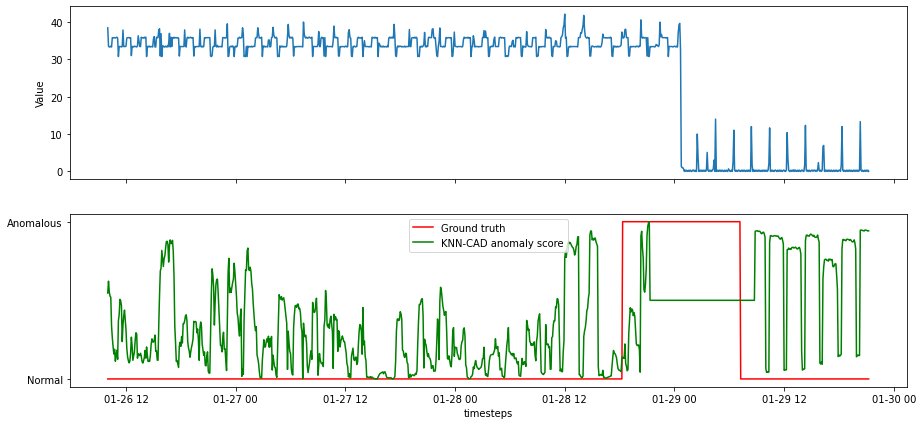

In [24]:
df = NAB["realAWSCloudwatch/grok_asg_anomaly.csv"][3000:4000]
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["gt"] = "Normal"
df["gt"][df["is_anomaly"] == 1] = "Anomalous"
fig, ax = plt.subplots(2, sharex=True, figsize=(15,7))
ax[0].plot(df["timestamp"], df["value"])
ax[0].set_ylabel("Value")
ax[1].plot(df["timestamp"], df["gt"], "red", label="Ground truth")
ax[1].plot(df["timestamp"], df["res_knn"], "green", label="KNN-CAD anomaly score")
ax[1].set_xlabel("timesteps")
plt.legend()

In [19]:
df

,timestamp,value,res_htm,is_anomaly,res_cadose,res_knn,res_earthgecko
0,2014-01-16 00:00:00,33.5573,0.030103,0,0.000000,0.000000,0.0
1,2014-01-16 00:05:00,33.4460,0.030103,0,0.000000,0.000000,0.0
2,2014-01-16 00:10:00,33.4447,0.030103,0,0.000000,0.000000,0.0
3,2014-01-16 00:15:00,33.3333,1.000000,0,0.000000,0.000000,0.0
4,2014-01-16 00:20:00,33.4447,0.030103,0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...
4616,2014-02-01 00:40:00,0.3380,0.016730,0,0.115385,0.000000,0.0
4617,2014-02-01 00:45:00,0.0000,0.016730,0,0.115385,0.011869,0.0
4618,2014-02-01 00:50:00,0.0000,0.016730,0,0.115385,0.001484,0.0
4619,2014-02-01 00:55:00,0.0000,0.016730,0,0.115385,0.002967,0.0
